## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('E:/PTDLKD/Đồ án/dataset/CTLT.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
5,2019-01-09,32.790001,33.430000,32.730000,33.380001,33.380001,894400
6,2019-01-10,33.189999,33.970001,32.970001,33.880001,33.880001,748700
7,2019-01-11,33.830002,33.930000,33.570000,33.750000,33.750000,639800
8,2019-01-14,33.540001,33.689999,33.299999,33.590000,33.590000,779700
9,2019-01-15,33.720001,34.264999,33.520000,34.070000,34.070000,867700


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show Dataframe
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...
2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500


## Describe Data

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03
mean,80.071323,81.264071,78.774144,80.051233,80.051233,1.451844e+06
std,30.077890,30.372008,29.679122,30.002664,30.002664,1.912181e+06
min,30.049999,30.660000,29.290001,29.840000,29.840000,2.197000e+05
25%,50.935000,51.800001,50.379999,51.329999,51.329999,7.148000e+05
50%,78.260002,79.400002,77.220001,78.550003,78.550003,1.004100e+06
75%,105.935001,107.257503,104.104999,106.025002,106.025002,1.475700e+06
max,142.639999,142.639999,140.779999,142.350006,142.350006,3.083880e+07


## Visualize Data

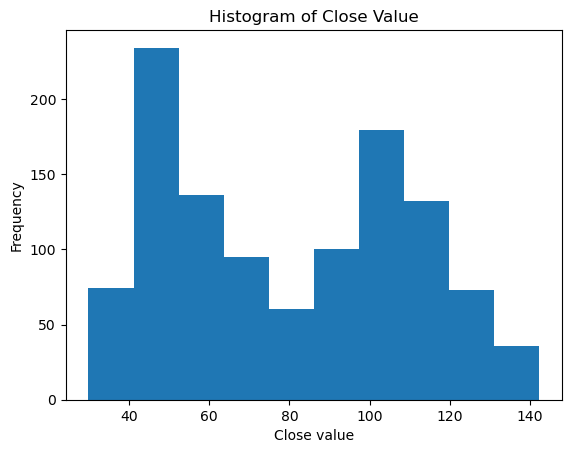

In [6]:
# Draw a histogram 
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

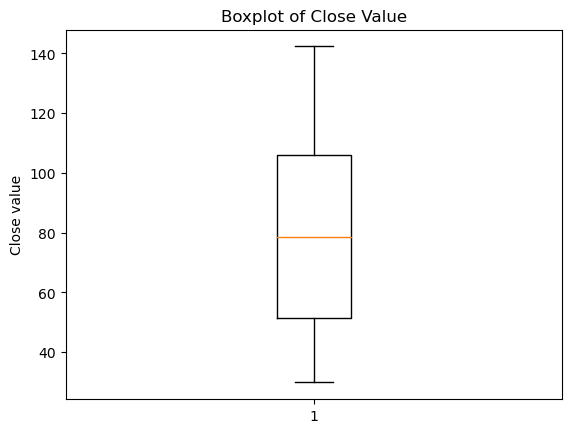

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Display boxplot
plt.show()

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [8]:
# Define the size of train, validation, test set
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

# Split the data into train, test and validation set
train_data = df.iloc[0 : train_size, :]
val_data = df.iloc[train_size : train_size + val_size, :]
test_data = df.iloc[train_size + val_size : len(df), :]

## Extracting features

Create function augment_features to calculate the fractional change in:
1. Opening and closing prices (fracocp)
2. High prices (frachp)
3. Low prices (fraclp)

In [9]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

Function extract_features will combine the 3 calculated fractional change into 1 array

In [10]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

## Build Model

In [11]:
# Set the quantity of hidden states is 10
model = GaussianHMM(n_components=10)

In [12]:
# Extract features of train set
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

# Training model
model.fit(features_train)

c:\Users\Admin\.conda\envs\user_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


GaussianHMM(n_components=10)

In [13]:
# Using 50 days in the past to predict the closing price of the current day
num_latent_days = 50

# Determine the number of days will be predicted is 30 days
num_days_to_predict = 30

## Evaluate in validation set

In [14]:
# Extract features of validation set
val_augmented = augment_features(val_data) 
val_fracocp = val_augmented['delOpenClose']
val_frachp = val_augmented['delHighOpen']
val_fraclp = val_augmented['delLowOpen']

# Divide validation set's feature values into parts
val_sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), 50) 
val_sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), 10)
val_sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), 10)

# Generate the possible permutations of values for the features of validation set
possible_outcomes = np.array(list(itertools.product(val_sample_space_fracocp, val_sample_space_frachp, val_sample_space_fraclp)))

In [15]:
# best_num_step stores the number of steps in the interval that the features take
best_num_step = None

# best_mae stores the best Mean Absolute Error value
best_mae = float('inf')

In [16]:
# Experiment and find the best number of steps between 10 and 50
for num_step in np.arange(10, 50, 10):
    sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    
    predicted_close_prices = []
    
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire validation data features for these days
        previous_data = extract_features(augment_features(val_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    
    # Calculate MAE value
    mae = (abs(val_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean()

    # Compare and find the best number of steps and the best MAE value
    if mae < best_mae:
        best_num_step = num_step
        best_mae = mae

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


In [17]:
# Show the best number of steps
print("The best number of steps is : ", best_num_step)

The best number of steps is :  30


## Predict model with the best number of steps

In [18]:
# Extract features of test set
test_augmented = augment_features(test_data) 
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

# Divide test set's feature values into parts
sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), best_num_step) 
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(best_num_step/5))
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(best_num_step/5))

# Generate the possible permutations of values for the features of test set
possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [19]:
y_pred = []

for i in tqdm(range(test_size - num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Calculate start and end indices
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data)) 
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    y_pred.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0])) 

100%|██████████| 195/195 [01:26<00:00,  2.27it/s]


## Calculate the error of the model

In [20]:
# Select the test values in reality
y_act = test_data.iloc[0 : test_size - num_days_to_predict]['Close']
y_act = y_act.values
y_act

array([110.099998, 107.610001, 107.919998, 107.629997, 109.410004,
       111.879997, 113.099998, 111.800003, 111.389999, 108.75    ,
       109.400002, 110.559998, 110.040001, 108.129997, 112.839996,
       109.940002, 109.970001, 110.849998, 109.220001, 108.400002,
       106.309998, 105.239998, 102.360001, 102.510002, 102.690002,
       104.199997,  99.699997,  92.279999,  89.279999,  88.      ,
        88.339996,  87.580002,  88.970001,  91.849998,  93.269997,
        95.970001,  96.050003,  91.870003,  91.900002,  89.239998,
        89.940002,  89.279999,  87.150002,  83.150002,  79.059998,
        76.07    ,  74.730003,  72.739998,  76.239998,  74.279999,
        72.360001,  76.519997,  79.790001,  81.      ,  78.709999,
        77.019997,  74.980003,  73.18    ,  73.199997,  74.150002,
        72.110001,  74.360001,  74.93    ,  71.080002,  68.269997,
        67.629997,  69.      ,  71.360001,  71.970001,  66.269997,
        66.18    ,  65.730003,  49.529999,  44.900002,  42.25 

In [21]:
# Select the test values in reality
test_mape = mean_absolute_percentage_error(y_act, y_pred)
test_mse = mean_squared_error(y_act, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_act, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.022920960691955275
RMSE on Test dataset:  1.9159104052154157
MSLE on Test dataset:  0.0008562343132756432


## Model visualization

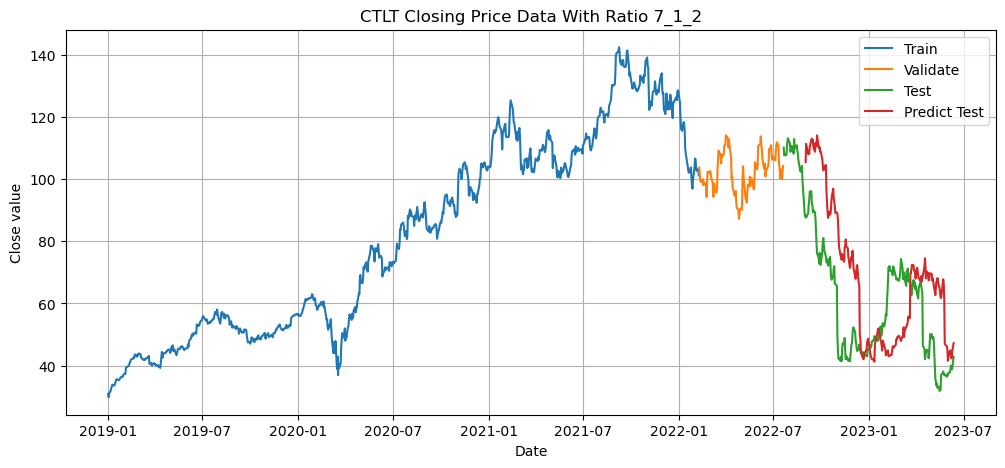

In [22]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data['Close'].values)

# Validation set
plt.plot(df[train_size : train_size + val_size].index, val_data['Close'].values)

# Test set
plt.plot(df[train_size + val_size: ].index, test_data['Close'].values)

# Predict in test set
plt.plot(df[train_size + val_size + num_days_to_predict:].index, y_pred)

# Predict 30 next days
# plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict Test'])
plt.grid()
plt.title("CTLT Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('HMM_712_CTLT.png')
plt.show()